<a href="https://colab.research.google.com/github/jincy-p-janardhanan/Text-Clustering/blob/main/Text_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preliminaries

In [1]:
! pip install contractions
! pip install autocorrect
! pip install pattern

In [2]:
import requests
import nltk
import contractions
import string
import autocorrect
import re
from gensim.utils import lemmatize

In [3]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Download dataset

In [4]:
def downloadfile(url, path):
  r = requests.get(url, stream=True)
  with open(path, "wb") as f:
    for block in r.iter_content(chunk_size=1024):
      if block:
        f.write(block)

In [5]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00314/%5bUCI%5d%20AAAI-13%20Accepted%20Papers%20-%20Papers.csv'
loc = '/content/'
filename = 'AAAI-accepted-papers-2013.csv'
path = loc+filename
downloadfile(url, path)

## Load Dataset

In [6]:
import pandas as pd

In [7]:
df = pd.read_csv(path)
df.head()

,Title,Keywords,Topics,High-Level Keyword(s),Abstract
0,The cascade auction – a mechanism for deterrin...,Mediators\nAuctions\nCollusion\nAd Exchanges,Auctions and Market-Based Systems\nE-Commerce\...,Multiagent Systems,We introduce a sealed bid auction of a single ...
1,Basis Adaptation for Sparse Nonlinear Reinforc...,Reinforcement learning\nSparsity\nMirror desce...,Dimension Reduction/Feature Selection\nOnline ...,Machine Learning\nReasoning under Uncertainty,This paper presents a new approach to basis ad...
2,Optimal Coalition Structures in Cooperative Gr...,Cooperative Game Theory\nCoalition Structure G...,Coordination and Collaboration\nGame Theory,Multiagent Systems,Representation languages for coalitional game...
3,External Memory Best-First Search for Multiple...,External-Memory Search\nParallel Search\nMulti...,Heuristic Search\nEvaluation and Analysis (Sea...,Heuristic Search and Optimization,Multiple sequence alignment (MSA) is a central...
4,Posted Prices Exchange for Display Advertising...,Display Advertising\nDynamic Pricing\nMarket E...,Auctions and Market-Based Systems\nE-Commerce\...,Multiagent Systems,We propose a new market design for display adv...


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Title                  150 non-null    object
 1   Keywords               150 non-null    object
 2   Topics                 150 non-null    object
 3   High-Level Keyword(s)  150 non-null    object
 4   Abstract               150 non-null    object
dtypes: object(5)
memory usage: 6.0+ KB


# Text Preprocessing

Null value check

In [9]:
missing_values = df.isna().sum()
print(missing_values[missing_values>0])

Series([], dtype: int64)


Apply various text transformations (on a copy of the dataframe).

In [10]:
df2 = df.copy(deep=True)

# convert to lower case
df2 = df2.apply(lambda x: x.str.lower())

# fix contractions (E.g. it's => it is, I'm => I am, etc.)
df2 = df2.apply(lambda x:[contractions.fix(i) for i in x])

# To make keywords to arrays, first replace [' or ', ' and ', '\n' , '(', ')', '/'] with ' \n '
keywordcols = ['Keywords', 'Topics', 'High-Level Keyword(s)']
df2[keywordcols] = df2[keywordcols].apply(lambda x:[re.sub('( or | and |\\n|\(|\)|\/)', ' \n ', i) for i in x])

# Replace special characters (preserving space and \n) in keyowrd cols
df2[keywordcols] = df2[keywordcols].apply(lambda x: [re.sub('[^a-z0-9 \n]', ' ', i) for i in x])

# Replace special characters (preserving only space) in nonkey cols
nonkeycols = list(set(df2.columns) - set(keywordcols))
df2[nonkeycols] = df2[nonkeycols].apply(lambda x: [re.sub('[^a-z0-9]', ' ', i) for i in x])

# correct any misspelled words before splitting keywords
corrector = autocorrect.Speller()
df2 = df2.apply(lambda x: [corrector(i) for i in x])
df2.head()

# tokenize keywords (for clustering based on keywords)
df2[keywordcols] = df2[keywordcols].apply(lambda x:[[j.strip() for j in i.split('\n')] for i in x])
# fix any empty strings in keyword lists and replace space by '_'
df2[keywordcols] = df2[keywordcols].apply(lambda x: [[('_'.join(j.split())) for j in i if j] for i in x])

# tokenize nonkey columns
df2[nonkeycols] = df2[nonkeycols].apply(lambda x:[nltk.tokenize.word_tokenize(i) for i in x])

# remove stop words from non key columns
df2[nonkeycols] = df2[nonkeycols].apply(
    lambda x: [
               [ w for w in wordlist if w not in nltk.corpus.stopwords.words('english')] 
               for wordlist in x])

Not sure of why this happens, but the `lemmatize()` function works only after a few retries.

In [11]:
# Lemmatize tokens in nonkey cols
for attempt in range(1, 11):
  try:
    print(f'Lemmatize attempt: {attempt}')
    df2[nonkeycols] = df2[nonkeycols].apply(lambda x: [ 
                  [ (l.decode('utf-8')).split('/', 1)[0]
                    for w in wordlist for l in lemmatize(w)]
                  for wordlist in x])
    print(f'Attempt {attempt} success!')
    break
  except:
    pass

Lemmatize attempt: 1
Lemmatize attempt: 2
Lemmatize attempt: 3
Lemmatize attempt: 4
Attempt 4 success!


In [12]:
df2.head()

,Title,Keywords,Topics,High-Level Keyword(s),Abstract
0,"[cascade, auction, mechanism, determine, collu...","[mediators, auctions, collusion, ad_exchanges]","[auctions, market_based_systems, e_commerce, g...",[multiagent_systems],"[introduce, seal, bid, auction, single, item, ..."
1,"[basis, adaptation, sparse, nonlinear, reinfor...","[reinforcement_learning, varsity, mirror_desce...","[dimension_reduction, feature_selection, onlin...","[machine_learning, reasoning_under_uncertainty]","[paper, present, new, approach, basis, adaptat..."
2,"[optimal, coalition, structure, cooperative, g...","[cooperative_game_theory, coalition_structure_...","[coordination, collaboration, game_theory]",[multiagent_systems],"[representation, language, coalition, game, ke..."
3,"[external, memory, best, first, search, multip...","[external_memory_search, parallel_search, mult...","[heuristic_search, evaluation, analysis, searc...","[heuristic_search, optimization]","[multiple, sequence, alignment, msa, central, ..."
4,"[post, price, exchange, display, advertising, ...","[display_advertising, dynamic_pricing, market_...","[auctions, market_based_systems, e_commerce, m...",[multiagent_systems],"[propose, new, market, design, display, advert..."


In [13]:
df.head()

,Title,Keywords,Topics,High-Level Keyword(s),Abstract
0,The cascade auction – a mechanism for deterrin...,Mediators\nAuctions\nCollusion\nAd Exchanges,Auctions and Market-Based Systems\nE-Commerce\...,Multiagent Systems,We introduce a sealed bid auction of a single ...
1,Basis Adaptation for Sparse Nonlinear Reinforc...,Reinforcement learning\nSparsity\nMirror desce...,Dimension Reduction/Feature Selection\nOnline ...,Machine Learning\nReasoning under Uncertainty,This paper presents a new approach to basis ad...
2,Optimal Coalition Structures in Cooperative Gr...,Cooperative Game Theory\nCoalition Structure G...,Coordination and Collaboration\nGame Theory,Multiagent Systems,Representation languages for coalitional game...
3,External Memory Best-First Search for Multiple...,External-Memory Search\nParallel Search\nMulti...,Heuristic Search\nEvaluation and Analysis (Sea...,Heuristic Search and Optimization,Multiple sequence alignment (MSA) is a central...
4,Posted Prices Exchange for Display Advertising...,Display Advertising\nDynamic Pricing\nMarket E...,Auctions and Market-Based Systems\nE-Commerce\...,Multiagent Systems,We propose a new market design for display adv...


In [14]:
df = df2.copy(deep=True)

# Visualization

In [15]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

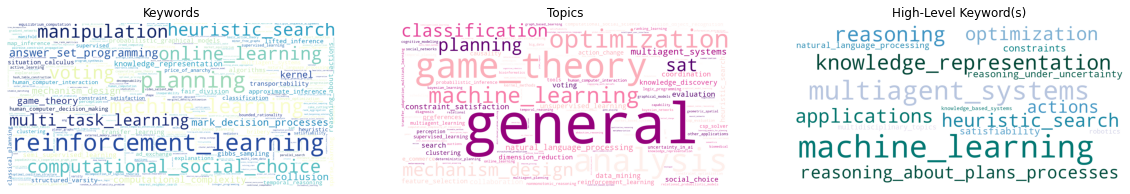

In [16]:
seed = 10
colormaps = ['YlGnBu', 'RdPu', 'PuBuGn']
plt.rcParams['figure.figsize'] = (20, 11)
for i in range(len(keywordcols)):
  wordcloud = WordCloud(collocations = False, width=1600, height=800, background_color='white', 
                        max_words=300, colormap=colormaps[i], random_state=seed
                        ).generate(' '.join([j for i in df[keywordcols[i]] for j in i]))
  
  plt.subplot(1, 3, i+1)
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.title(keywordcols[i])
plt.show()

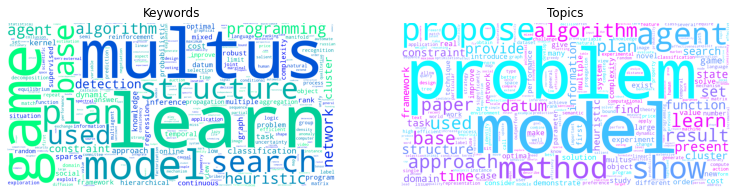

In [23]:
colormaps = ['winter', 'cool']
plt.rcParams['figure.figsize'] = (20, 11)
for i in range(len(nonkeycols)):
  wordcloud = WordCloud(collocations = False, width=1600, height=800, background_color='white', 
                        max_words=300, colormap=colormaps[i], random_state=seed
                        ).generate(' '.join([j for i in df[nonkeycols[i]] for j in i]))
  
  plt.subplot(1, 3, i+1)
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.title(keywordcols[i])
plt.show()